
# Week3_01: 猫種分類モデルの学習（Transfer Learning）

このNotebookは **転移学習** で猫種分類モデルを学習するためのテンプレートです。  
以下の順に進めます：

1. 環境確認・ライブラリの導入
2. 設定（データパス・ハイパーパラメータ）
3. データセット＆データローダ（学習/検証/テスト）
4. モデル構築（事前学習モデルの微調整）
5. 学習ループ（AMP対応 & 早期終了）
6. 評価（Accuracy・F1・混同行列・クラス別）
7. モデル保存（.pt）＆メタ情報（クラス名など）
8. 推論デモ（単一画像/フォルダ）
9. エクスポート（TorchScript / ONNX 任意）

> **NOTE**: データの場所やクラス数はプロジェクト状況に合わせて`CONFIG`を書き換えてください。


## 1. 環境確認・ライブラリの導入

In [1]:

# %%capture
# インストールが必要な場合は解除してください
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install scikit-learn matplotlib pandas tqdm pillow timm

import os, sys, json, time, random, math, shutil
from pathlib import Path
from dataclasses import dataclass, asdict
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

try:
    import timm  # 多様なSOTAモデルを使う場合
except Exception as e:
    timm = None

print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


Python: 3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]
PyTorch: 2.9.0+cpu
CUDA available: False


device(type='cpu')

## 2. 設定（データパス・ハイパーパラメータ）

In [4]:

@dataclass
class Config:
    # === パス周り ===
    # 例: プロジェクト構成に合わせて更新
    # raw→processed_catsへの前処理はWeek2で済んでいる想定
    project_root: str = str(Path.cwd())
    data_dir: str = "../data/oxford-iiit-pet/processed_cats"
    train_dir: str = "train"
    val_dir: str = "val"
    test_dir: str = "test"
    # クラス名ファイル（任意）: data_dir/classes.json に ["Abyssinian", ...] の形で保存されている想定
    classes_file: str = "classes.json"
    # 保存先
    out_dir: str = "artifacts/week3"
    run_name: str = time.strftime("run_%Y%m%d_%H%M%S")

    # === 学習設定 ===
    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 4
    epochs: int = 15
    lr: float = 1e-3
    weight_decay: float = 1e-4
    model_name: str = "resnet50"  # "resnet50" / "efficientnet_b0" / (timmモデル名)
    pretrained: bool = True
    freeze_backbone: bool = False  # Trueにすると全結合層以外を凍結
    label_smoothing: float = 0.0
    early_stop_patience: int = 5

    # データ拡張
    use_aug: bool = True
    mixup_alpha: float = 0.0  # 0で無効

CFG = Config()

# 便利パス
DATA = Path(CFG.project_root) / CFG.data_dir
TRAIN = DATA / CFG.train_dir
VAL = DATA / CFG.val_dir
TEST = DATA / CFG.test_dir
OUT = Path(CFG.project_root) / CFG.out_dir / CFG.run_name
OUT.mkdir(parents=True, exist_ok=True)

print('DATA:', DATA.resolve())
print('OUT :', OUT.resolve())


DATA: C:\Users\81802\Portfolio\catbreed-portfolio\backend\data\oxford-iiit-pet\processed_cats
OUT : C:\Users\81802\Portfolio\catbreed-portfolio\backend\notebooks\artifacts\week3\run_20251109_151018


## 3. データセット & データローダ

In [5]:

# クラス名の決定
classes = None
classes_path = DATA / CFG.classes_file
if classes_path.exists():
    classes = json.loads(classes_path.read_text())
    print(f"Loaded classes from {classes_path}: {len(classes)} classes")
else:
    # ディレクトリ名から推測（ImageFolderと同じルール）
    if TRAIN.exists():
        classes = sorted([d.name for d in TRAIN.iterdir() if d.is_dir()])
        print("Inferred classes from train subdirs:", len(classes))
    else:
        print("WARN: TRAIN dir not found. Please set DATA paths correctly.")
        classes = []

num_classes = len(classes) if classes else None
print("num_classes:", num_classes)

# 変換
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.RandomHorizontalFlip() if CFG.use_aug else transforms.Lambda(lambda x: x),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tfms = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ImageFolderを用いる想定（train/val/testの各クラスフォルダ構成）
train_ds = datasets.ImageFolder(TRAIN, transform=train_tfms) if TRAIN.exists() else None
val_ds   = datasets.ImageFolder(VAL,   transform=eval_tfms) if VAL.exists()   else None
test_ds  = datasets.ImageFolder(TEST,  transform=eval_tfms) if TEST.exists()  else None

if train_ds:
    assert num_classes == len(train_ds.classes), "classes.json と trainサブディレクトリの不一致があり得ます"
    print("Detected classes:", train_ds.classes[:5], "...")

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True,  num_workers=CFG.num_workers) if train_ds else None
val_loader   = DataLoader(val_ds,   batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers) if val_ds   else None
test_loader  = DataLoader(test_ds,  batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers) if test_ds  else None


Inferred classes from train subdirs: 12
num_classes: 12
Detected classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British'] ...


## 4. モデル構築（事前学習モデルの微調整）

In [6]:

def build_model(model_name: str, num_classes: int, pretrained: bool = True, freeze_backbone: bool = False):
    if model_name.startswith("efficientnet_b"):
        model = getattr(models, model_name)(weights="IMAGENET1K_V1" if pretrained else None)
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes)
        backbone = [n for n, _ in model.named_parameters() if not n.startswith("classifier")]
    elif model_name.startswith("resnet"):
        model = getattr(models, model_name)(weights="IMAGENET1K_V1" if pretrained else None)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        backbone = [n for n, _ in model.named_parameters() if not n.startswith("fc")]
    elif timm is not None:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        backbone = [n for n, _ in model.named_parameters() if "classifier" not in n and "fc" not in n and "head" not in n]
    else:
        raise ValueError(f"Unsupported model_name={model_name}. Install timm for more options.")

    if freeze_backbone:
        for name, p in model.named_parameters():
            if name in backbone:
                p.requires_grad = False
    return model

assert num_classes is not None and num_classes > 1, "クラス数が不明です。データパス設定を確認してください。"
model = build_model(CFG.model_name, num_classes, CFG.pretrained, CFG.freeze_backbone).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=CFG.label_smoothing)
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=CFG.lr, weight_decay=CFG.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

sum(p.numel() for p in model.parameters() if p.requires_grad), model.__class__.__name__


0.5%

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\81802/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100.0%
C:\Users\81802\AppData\Local\Temp\ipykernel_11504\624066699.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


(23532620, 'ResNet')

In [8]:
!pip install tqdm

## 5. 学習ループ（AMP対応 & 早期終了）

In [9]:

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def train_one_epoch(model, loader, optimizer, scaler, device):
    model.train()
    losses = []
    preds_all, t_all = [], []
    for x, t in tqdm(loader or [], desc="train", leave=False):
        x, t = x.to(device), torch.as_tensor(t, device=device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            y = model(x)
            loss = criterion(y, t)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.detach().item())
        preds_all.append(y.detach().argmax(1).cpu().numpy())
        t_all.append(t.detach().cpu().numpy())
    if len(losses)==0:
        return {"loss": None, "acc": None, "f1": None}
    preds_all = np.concatenate(preds_all)
    t_all = np.concatenate(t_all)
    return {
        "loss": float(np.mean(losses)),
        "acc": float(accuracy_score(t_all, preds_all)),
        "f1": float(f1_score(t_all, preds_all, average="macro")),
    }

@torch.inference_mode()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    preds_all, t_all = [], []
    for x, t in tqdm(loader or [], desc="valid", leave=False):
        x, t = x.to(device), torch.as_tensor(t, device=device)
        y = model(x)
        loss = criterion(y, t)
        losses.append(loss.detach().item())
        preds_all.append(y.detach().argmax(1).cpu().numpy())
        t_all.append(t.detach().cpu().numpy())
    if len(losses)==0:
        return {"loss": None, "acc": None, "f1": None}
    preds_all = np.concatenate(preds_all)
    t_all = np.concatenate(t_all)
    return {
        "loss": float(np.mean(losses)),
        "acc": float(accuracy_score(t_all, preds_all)),
        "f1": float(f1_score(t_all, preds_all, average="macro")),
        "preds": preds_all,
        "targets": t_all,
    }

history = []
best_acc = -1
patience = 0
for epoch in range(1, CFG.epochs+1):
    print(f"\nEpoch {epoch}/{CFG.epochs}")
    tr = train_one_epoch(model, train_loader, optimizer, scaler, device)
    va = evaluate(model, val_loader, device)

    rec = {"epoch": epoch, "train": tr, "val": {k: va.get(k) for k in ["loss","acc","f1"]}}
    history.append(rec)
    pd.DataFrame(history).to_json(OUT / "history.json", orient="records", force_ascii=False, indent=2)
    print(rec)

    if va["acc"] is not None and va["acc"] > best_acc:
        best_acc = va["acc"]
        patience = 0
        torch.save({"model": model.state_dict(), "classes": classes, "cfg": asdict(CFG)}, OUT / "best.pt")
        print(f"Saved best.pt  (val_acc={best_acc:.4f})")
    else:
        patience += 1
        if patience >= CFG.early_stop_patience:
            print("Early stopping.")
            break



Epoch 1/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 1, 'train': {'loss': 1.464785893758138, 'acc': 0.48575949367088606, 'f1': 0.48592638794913184}, 'val': {'loss': 4.986859565600753, 'acc': 0.22362869198312235, 'f1': 0.14610725148676512}}
Saved best.pt  (val_acc=0.2236)

Epoch 2/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 2, 'train': {'loss': 1.0608177572488784, 'acc': 0.629746835443038, 'f1': 0.6280509013352499}, 'val': {'loss': 1.0262634265236557, 'acc': 0.6582278481012658, 'f1': 0.6470907560981582}}
Saved best.pt  (val_acc=0.6582)

Epoch 3/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 3, 'train': {'loss': 0.8128746251265208, 'acc': 0.7225738396624473, 'f1': 0.7226530998246906}, 'val': {'loss': 0.8543645143508911, 'acc': 0.6751054852320675, 'f1': 0.669088400342357}}
Saved best.pt  (val_acc=0.6751)

Epoch 4/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 4, 'train': {'loss': 0.6699694663286209, 'acc': 0.7837552742616034, 'f1': 0.7837041920287654}, 'val': {'loss': 0.9880040921270847, 'acc': 0.6540084388185654, 'f1': 0.6550318228534066}}

Epoch 5/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 5, 'train': {'loss': 0.6362755859891573, 'acc': 0.7906118143459916, 'f1': 0.7910655287320413}, 'val': {'loss': 1.0079582519829273, 'acc': 0.6708860759493671, 'f1': 0.6445807953915048}}

Epoch 6/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 6, 'train': {'loss': 0.43675525635480883, 'acc': 0.8517932489451476, 'f1': 0.8521061713021458}, 'val': {'loss': 0.9109876155853271, 'acc': 0.70042194092827, 'f1': 0.7113097261972018}}
Saved best.pt  (val_acc=0.7004)

Epoch 7/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 7, 'train': {'loss': 0.4885949472586314, 'acc': 0.8370253164556962, 'f1': 0.8371576196686829}, 'val': {'loss': 1.0619335621595383, 'acc': 0.6540084388185654, 'f1': 0.6579374611043587}}

Epoch 8/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 8, 'train': {'loss': 0.43557350859045985, 'acc': 0.8533755274261603, 'f1': 0.8539311185159165}, 'val': {'loss': 1.0296079479157925, 'acc': 0.6708860759493671, 'f1': 0.6749864175204477}}

Epoch 9/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 9, 'train': {'loss': 0.40989984199404716, 'acc': 0.865506329113924, 'f1': 0.8657536473469318}, 'val': {'loss': 0.8493549674749374, 'acc': 0.7383966244725738, 'f1': 0.7288240585030553}}
Saved best.pt  (val_acc=0.7384)

Epoch 10/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 10, 'train': {'loss': 0.41432728183766204, 'acc': 0.8560126582278481, 'f1': 0.8563171034477076}, 'val': {'loss': 0.9019240434281528, 'acc': 0.7257383966244726, 'f1': 0.7233020621437626}}

Epoch 11/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 11, 'train': {'loss': 0.30106099707384903, 'acc': 0.9003164556962026, 'f1': 0.9005618569997873}, 'val': {'loss': 0.7640675511211157, 'acc': 0.7805907172995781, 'f1': 0.7758354678565439}}
Saved best.pt  (val_acc=0.7806)

Epoch 12/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 12, 'train': {'loss': 0.330672184129556, 'acc': 0.895042194092827, 'f1': 0.8952795397217908}, 'val': {'loss': 0.9195866794325411, 'acc': 0.7426160337552743, 'f1': 0.7333507419443994}}

Epoch 13/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 13, 'train': {'loss': 0.21424040133133532, 'acc': 0.930379746835443, 'f1': 0.930629573646499}, 'val': {'loss': 0.8134949170053005, 'acc': 0.7805907172995781, 'f1': 0.7789865194181612}}

Epoch 14/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


{'epoch': 14, 'train': {'loss': 0.20478871334344148, 'acc': 0.9277426160337553, 'f1': 0.927881048071146}, 'val': {'loss': 0.6178305726498365, 'acc': 0.8059071729957806, 'f1': 0.8028832533397506}}
Saved best.pt  (val_acc=0.8059)

Epoch 15/15


train:   0%|          | 0/60 [00:00<?, ?it/s]C:\Users\81802\AppData\Local\Temp\ipykernel_11504\3644167584.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                                                      

{'epoch': 15, 'train': {'loss': 0.14548434192935625, 'acc': 0.9541139240506329, 'f1': 0.9543344862604219}, 'val': {'loss': 0.6734268618747592, 'acc': 0.7848101265822784, 'f1': 0.7778189374477499}}


## 6. 評価（混同行列・クラス別スコア）

              precision    recall  f1-score   support

  Abyssinian     0.6296    0.8500    0.7234        20
      Bengal     0.9231    0.6000    0.7273        20
      Birman     0.8421    0.8000    0.8205        20
      Bombay     0.8636    1.0000    0.9268        19
     British     0.8889    0.8000    0.8421        20
    Egyptian     0.8889    0.8421    0.8649        19
       Maine     0.7895    0.7500    0.7692        20
     Persian     0.7917    0.9500    0.8636        20
     Ragdoll     0.8500    0.8500    0.8500        20
     Russian     0.8500    0.8500    0.8500        20
     Siamese     1.0000    0.5500    0.7097        20
      Sphynx     0.7037    0.9500    0.8085        20

    accuracy                         0.8151       238
   macro avg     0.8351    0.8160    0.8130       238
weighted avg     0.8347    0.8151    0.8123       238



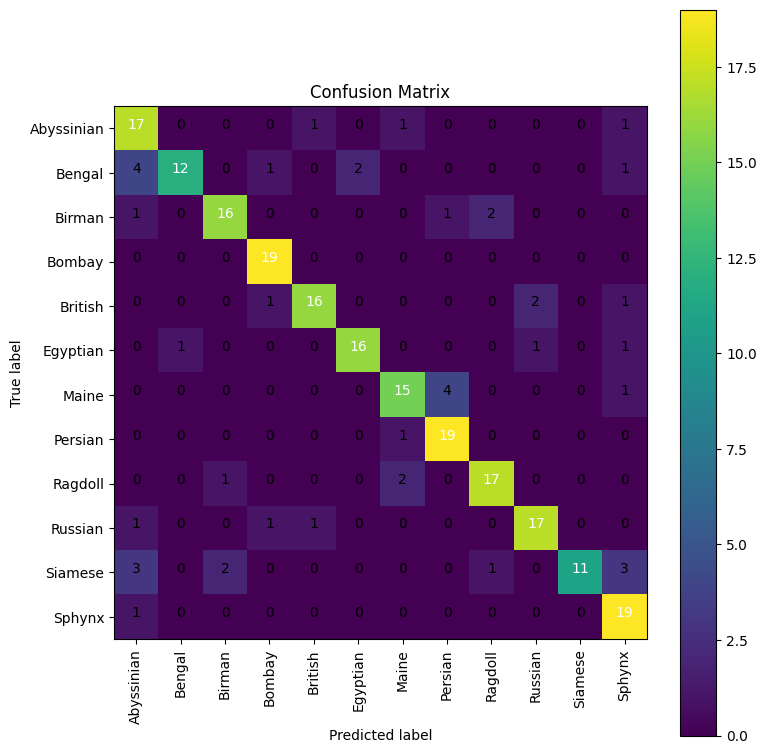

In [ ]:

from sklearn.metrics import confusion_matrix, classification_report
@torch.inference_mode()
def evaluate_full(model, loader, classes):
    model.eval()
    preds_all, t_all = [], []
    for x, t in tqdm(loader or [], desc="test", leave=False):
        x = x.to(device)
        y = model(x)
        preds_all.append(y.detach().argmax(1).cpu().numpy())
        t_all.append(t.numpy())
    if len(preds_all)==0:
        print("No test data.")
        return None
    preds_all = np.concatenate(preds_all)
    t_all = np.concatenate(t_all)
    cm = confusion_matrix(t_all, preds_all)
    print(classification_report(t_all, preds_all, target_names=classes, digits=4))
    return cm, preds_all, t_all

# 混同行列の描画
def plot_confusion_matrix(cm, classes, figsize=(8,8)):
    import itertools
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# テスト評価
cm, preds, targets = evaluate_full(model, test_loader, classes)
if cm is not None:
    plot_confusion_matrix(cm, classes)


## 7. 保存物（モデル＆メタ情報）

In [11]:

# 既にbest.ptは保存済み。最後にクラス名や設定を明示的に保存
(Path(OUT) / "classes.json").write_text(json.dumps(classes, ensure_ascii=False, indent=2))
(Path(OUT) / "config.json").write_text(json.dumps(asdict(CFG), ensure_ascii=False, indent=2))
print("Saved classes.json and config.json to", OUT)


Saved classes.json and config.json to c:\Users\81802\Portfolio\catbreed-portfolio\backend\notebooks\artifacts\week3\run_20251109_151018


## 8. 推論デモ

In [17]:

from torchvision.io import read_image

@torch.inference_mode()
def predict_image(img_path: str, model, classes, img_size=CFG.img_size):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    x = tfm(img).unsqueeze(0).to(device)
    y = model(x)
    prob = torch.softmax(y, dim=1)[0].cpu().numpy()
    idx = int(prob.argmax())
    return {
        "pred_class": classes[idx],
        "pred_index": idx,
        "prob": float(prob[idx]),
        "top5": sorted([(classes[i], float(p)) for i,p in enumerate(prob)], key=lambda z: z[1], reverse=True)[:5]
    }

img_path = r"C:\Users\81802\Downloads\ragdoll.jpg"
pred = predict_image(img_path, model, classes)
pred


{'pred_class': 'Ragdoll',
 'pred_index': 8,
 'prob': 0.994161069393158,
 'top5': [('Ragdoll', 0.994161069393158),
  ('Sphynx', 0.0032007689587771893),
  ('Birman', 0.0015112383989617229),
  ('Persian', 0.0010366940405219793),
  ('Maine', 8.374437311431393e-05)]}

## 9. エクスポート（任意）

In [ ]:

# TorchScript
try:
    example = torch.randn(1, 3, CFG.img_size, CFG.img_size).to(device)
    ts = torch.jit.trace(model, example)
    torch.jit.save(ts, OUT / "model.torchscript.pt")
    print("Saved TorchScript:", (OUT/"model.torchscript.pt").resolve())
except Exception as e:
    print("TorchScript export skipped:", e)

# ONNX
try:
    onnx_path = OUT / "model.onnx"
    torch.onnx.export(
        model, example, onnx_path.as_posix(), input_names=["input"], output_names=["logits"],
        opset_version=17, dynamic_axes={"input":{0:"batch"}, "logits":{0:"batch"}}
    )
    print("Saved ONNX:", onnx_path.resolve())
except Exception as e:
    print("ONNX export skipped:", e)
